## Table of Contents
* [1. Downloading data](#1)
* [2. Model Fitting & Evaluation](#models)
    * [3.1. Linear Regression](#3_linreg)
    * [3.2. Ridge](#3_ridge)
    * [3.3. Lasso](#3_lasso)
    * [3.4. k-Nearest Neighbors](#3_knn)
    * [3.5. Decision Tree](#3_tree)
    * [3.6. Random Forest](#3_forest)
    * [3.7. Ensemble Method](#3_ensemble)
        * [3.7.1. Voting Regressor](#3_voting)
        * [3.7.2. Bagging Regressor](#3_bagging)
        * [3.7.3. AdaBoost Regressor](#3_adaboost)
        * [3.7.4. Gradient Boosting Regressor](#3_gradient)
        * [3.7.5. XGBoost](#3_xgboost)
        * [3.7.6. Stacked Ensembles](#3_stacked)
* [3. Conclusion](#conclusion)
* [4. MLflow Tracking](#mlflow)


In [1]:
import pandas as pd
import numpy as np
import time
import itertools

# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib import cm


In [ ]:
from functions.functions import load_data
from functions.functions import to_split_and_scale, namestr, reg_model_implementation, show_feature_importances


<a id="1"></a>

# 1. Downloading data

In [ ]:
price_df4, cat_features, num_features, target = load_data()

In [2]:
# price_df4 = pd.read_csv("poland_apartments_completed.csv")
# price_df4.head()

,Unnamed: 0,id,city,floor,latitude,longitude,price,rooms,sq,year,latitude_center,longitude_center,decade,price_per_m,sq_round,radius,radius_dec,radius_ceil,district
0,0,23918.0,Kraków,2,50.049224,19.970379,749000,3,74,2021,50.061389,19.937222,2020,10121,70,2.732975,2.7,3,Dzielnica XIII Podgórze
1,1,17828.0,Warszawa,3,52.249775,21.106886,240548,1,24,2021,52.230000,21.011111,2020,10022,20,6.902500,6.9,7,Praga Południe
2,2,22784.0,Kraków,2,50.066964,19.920025,427000,2,37,1970,50.061389,19.937222,1970,11540,30,1.378660,1.4,2,Dzielnica V Krowodrza
3,3,4315.0,Poznañ,2,52.404212,16.882542,1290000,5,166,1935,52.408333,16.933611,1930,7771,160,3.505600,3.5,4,Grunwald
4,4,11770.0,Warszawa,1,52.212225,20.972630,996000,5,105,2020,52.230000,21.011111,2020,9485,100,3.290526,3.3,4,Ochota


In [3]:
# cat_features = ['city', 'district'] # 'floor', 'rooms'?
# num_features = ['floor', 'rooms', 'sq', 'year', 'radius']
# target = ['price']


<a id="models"></a>

# 2. Model Fitting & Evaluation

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict

from sklearn.metrics import mean_squared_error
from sklearn.metrics import *

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PowerTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# import xgboost as xgb

import mlflow
import mlflow.sklearn

# import pickle
# from mlflow import log_metric, log_param, log_artifact
from mlflow.models.signature import infer_signature


In [33]:
X_train_scaled, X_test_scaled, y_train, y_test, st_scaler, labels_dict = to_split_and_scale(price_df4, cat_features, num_features, target)


/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_55249/700610241.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


<a id="linreg"></a>

## 2.1. Linear Regression

In [16]:
linreg = reg_model_implementation(LinearRegression, {}, X_train_scaled, y_train, X_test_scaled, y_test)

Model: LinearRegression

R2-score:   0.6456541217381851
RMSE:       335535.75144777086

Time using clf_model_implementation(): 0.1679 sec


<a id="ridge"></a>

## 2.2. Ridge

In [534]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# GridSearchCV(ridge, grid, cv=kf)
grid = {
    "alpha": np.logspace(-4, 5, 10),
    "solver": ["sag", "lsqr"]
}

ridge = reg_model_implementation(Ridge, grid, X_train_scaled, y_train, X_test_scaled, y_test)

Model: Ridge
Tuned hyperparameters:
	alpha: 100.0
	solver: lsqr

R2-score:   0.6443024610501176
RMSE:       336175.0968370143

Time using clf_model_implementation(): 2.2347 sec


<a id="lasso"></a>

## 2.3. Lasso

In [535]:
grid = {
    "alpha": np.logspace(-4, 5, 10),
    "max_iter": [1000]
}

lasso = reg_model_implementation(Lasso, grid, X_train_scaled, y_train, X_test_scaled, y_test)

Model: Lasso
Tuned hyperparameters:
	alpha: 1000.0
	max_iter: 1000

R2-score:   0.645012570639768
RMSE:       335839.3615593049

Time using clf_model_implementation(): 29.0306 sec


<a id="knn"></a>

## 2.4. k-Nearest Neighbors

In [536]:
grid = {
    "n_neighbors": range(4, 10, 1),
    "leaf_size": range(20, 40, 5),
    "p": range(2, 5, 1),
    "algorithm": ['auto', 'ball_tree'] # ‘kd_tree’, ‘brute’
}

knn = reg_model_implementation(KNeighborsRegressor, grid, X_train_scaled, y_train, X_test_scaled, y_test)

Model: KNeighborsRegressor
Tuned hyperparameters:
	algorithm: auto
	leaf_size: 30
	n_neighbors: 9
	p: 2

R2-score:   0.7752411203771884
RMSE:       267228.97000866674

Time using clf_model_implementation(): 434.8763 sec


<a id="tree"></a>

## 2.5. Decision Tree

In [537]:
grid = {
    "min_samples_split": range(10, 30, 2),
    "max_depth": range(4, 10, 2),
#     "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    "splitter": ['best', 'random']
}

tree = reg_model_implementation(DecisionTreeRegressor, grid, X_train_scaled, y_train, X_test_scaled, y_test)

Model: DecisionTreeRegressor
Tuned hyperparameters:
	max_depth: 8
	min_samples_split: 18
	splitter: best

R2-score:   0.7744780307588892
RMSE:       267682.22654279147

Time using clf_model_implementation(): 5.4922 sec


<a id="forest"></a>

## 2.6. Random Forest

In [539]:
grid = {
    "n_estimators": [200, 300], # range(100, 400, 100)
    "max_depth": [8, 10], # range(4, 10, 2)
    "min_samples_split": [20, 30], # range(20, 40, 10)
    "n_jobs": [-1],
    "random_state": [42]
}

forest = reg_model_implementation(RandomForestRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())

# .values.ravel() - only for RandomForest because of https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected


Model: RandomForestRegressor
Tuned hyperparameters:
	max_depth: 10
	min_samples_split: 20
	n_estimators: 300
	n_jobs: -1
	random_state: 42

R2-score:   0.8303499723268795
RMSE:       232167.84801937971

Time using clf_model_implementation(): 52.7816 sec


<a id="ensemble"></a>

## 2.7. Ensemble Methods

<a id="ensemble_voting"></a>

### 2.7.1. Voting Regressor

In [159]:
def reg_voting_by_weights(weights_list): 
    reg_voting = VotingRegressor(
        estimators=[
            ('linreg', linreg),
            ('ridge', ridge),
            ('tree', tree),
            ('forest', forest)
        ],
        weights=weights_list
    )

    reg_voting.fit(X_train_scaled, y_train)
    y_pred_reg_voting = reg_voting.predict(X_test_scaled)

    # R-squared, RMSE
#     print(reg_voting.score(X_test_scaled, y_test))
#     print(mean_squared_error(y_test, y_pred_reg_voting, squared=False))
    return reg_voting.score(X_test_scaled, y_test), mean_squared_error(y_test, y_pred_reg_voting, squared=False)

# weights = [0, 0, 0, 4]
# weights = [1, 1, 3, 4]
# reg_voting_by_weights(weights)

In [355]:
from itertools import product

rrange = [1,2,3]
max_score = 0
weights_for_max = []

for p in product(rrange, repeat=4):
    weights = list(p)
    print(weights)
    score, mse = reg_voting_by_weights(weights)
    if score > max_score:
        max_score = score
        weights_for_max = weights
print()
print(max_score)
print(weights_for_max)

[1, 1, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 1, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 2, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1, 3, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 1, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 2, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2, 3, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 1, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 2, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 1, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 1, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 1, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 2, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 2, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 2, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 3, 1]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 3, 2]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3, 3, 3, 3]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



0.806729441144687
[1, 1, 3, 3]


<a id="ensemble_bagging"></a>

### 2.7.2. Bagging Regressor

In [356]:
# for linreg

bag_reg = BaggingRegressor(
    estimator=linreg, 
    n_estimators=40, 
    max_features=7, 
    max_samples=0.5, 
    bootstrap=True, # oob_score=True,
    random_state=42
)
# , bootstrap=True

bag_reg.fit(X_train_scaled, y_train)
y_pred_bag_reg = bag_reg.predict(X_test_scaled)

print(bag_reg.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_bag_reg, squared=False))


0.6452611033502875
335721.77756306174


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:510: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


In [357]:
# for ridge

bag_reg = BaggingRegressor(
    estimator=ridge, 
    n_estimators=10, 
    max_features=7, 
    max_samples=0.3, 
    bootstrap=True, # oob_score=True,
    random_state=42
)
# , bootstrap=True

bag_reg.fit(X_train_scaled, y_train)
y_pred_bag_reg = bag_reg.predict(X_test_scaled)

print(bag_reg.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_bag_reg, squared=False))


0.6483371008180494
334263.0599853332


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:510: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


<a id="ensemble_adaboost"></a>

### 2.7.3. AdaBoost Regressor

In [541]:
# for linreg:

grid = {
    "estimator": [linreg],
    "n_estimators": [60],
    "learning_rate": [0.01],
    "loss": ['linear'],
    "random_state": [42]
}

reg_ada_linreg = reg_model_implementation(AdaBoostRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())


Model: AdaBoostRegressor
Tuned hyperparameters:
	estimator: LinearRegression()
	learning_rate: 0.01
	loss: linear
	n_estimators: 60
	random_state: 42

R2-score:   0.6482317873391715
RMSE:       334313.1075886529

Time using clf_model_implementation(): 35.7458 sec


In [542]:
# for reg_xgb:

grid = {
    "estimator": [reg_xgb],
    "n_estimators": [60],
    "learning_rate": [0.01],
    "loss": ['linear'],
    "random_state": [42]
}

reg_ada_xgb = reg_model_implementation(AdaBoostRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())


KeyboardInterrupt: 

<a id="ensemble_gradient"></a>

### 2.7.4. Gradient Boosting Regressor

In [543]:
grid = {
    "n_estimators": [300],
    "learning_rate": [0.1],
    "random_state": [42]
}

clf_gb = reg_model_implementation(GradientBoostingRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())


Model: GradientBoostingRegressor
Tuned hyperparameters:
	learning_rate: 0.1
	n_estimators: 300
	random_state: 42

R2-score:   0.8453910688985511
RMSE:       221637.06850568793

Time using clf_model_implementation(): 39.0604 sec


<a id="ensemble_xgboost"></a>

### 2.7.5. XGBoost

In [548]:
grid = {
    "n_estimators": [200, 300], # range(100, 400, 100)
    "max_depth": range(4, 10, 2),
    "learning_rate": [0.1, 0.2, 0.3],
    "n_jobs": [-1],
    "objective": ['reg:squarederror'],
    "random_state": [42]
}

reg_xgb = reg_model_implementation(XGBRegressor, grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())


Model: XGBRegressor
Tuned hyperparameters:
	learning_rate: 0.2
	max_depth: 6
	n_estimators: 200
	n_jobs: -1
	objective: reg:squarederror
	random_state: 42

R2-score:   0.8582016430842119
RMSE:       212256.35781101728

Time using clf_model_implementation(): 291.0094 sec


In [475]:
reg_xgb = XGBRegressor(max_depth=8, learning_rate=0.2, n_estimators=200, n_jobs=2, objective='reg:squarederror', random_state=42)
reg_xgb.fit(X_train_scaled, y_train)
y_pred_reg_xgb = reg_xgb.predict(X_test_scaled)

print(reg_xgb.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_reg_xgb, squared=False))


0.873548997031265
200440.85549336098


**Why the result for best parameters isn't the best?**

Hyperparameter tuning is performed on the validation (development) set, not on the training set.

Grid Search Cross-Validation is using the K-Fold strategy to build a validation set that is used only for validation, not for training.

More details: https://stackoverflow.com/questions/64256966/grid-search-not-giving-the-best-parameters

feature: city,	 score: 0.11265
feature: district,	 score: 0.12594
feature: floor,	 score: 0.05862
feature: rooms,	 score: 0.04583
feature: sq,	 score: 0.48116
feature: year,	 score: 0.07549
feature: radius,	 score: 0.10030


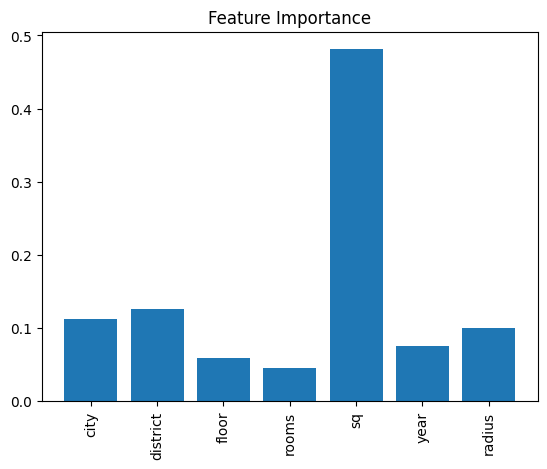

1

In [480]:
show_feature_importances(reg_xgb)

In [27]:
# import catboost as cb
# couldn't install 

In [ ]:
# reg_cat = cb.CatBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=500)
# reg_cat.fit(X_train_scaled, y_train)
# y_pred_reg_cat = reg_cat.predict(X_test_scaled)

# print(reg_cat.score(X_test_scaled, y_test))
# print(mean_squared_error(y_test, y_pred_reg_cat, squared=False))


In [28]:
# import lightgbm as lgb
# try to install !!

In [ ]:
# reg_lgb = lgb.LGBMRegressor(max_depth = 3, learning_rate = 0.1, n_estimators = 100, objective='mean_squared_error', seed=500)
# reg_lgb.fit(X_train_scaled, y_train)
# y_pred_reg_lgb = reg_lgb.predict(X_test_scaled)

# print(reg_lgb.score(X_test_scaled, y_test))
# print(mean_squared_error(y_test, y_pred_reg_lgb, squared=False))



<a id="ensemble_stacked"></a>

### 2.7.6. Stacked Ensembles

In [361]:
# from sklearn.ensemble

from sklearn.ensemble import StackingRegressor

# Prepare the list of tuples with the first-layer classifiers
regressors = [
    ('linreg', linreg),
    ('ridge', ridge),
    ('tree', tree),
    ('forest', forest)
]
# Instantiate the second-layer meta estimator
reg_meta = LinearRegression()

reg_stack = StackingRegressor(
    estimators=regressors,
    final_estimator=reg_meta,
#     stack_method='predict_proba',
    passthrough = False
)

reg_stack.fit(X_train_scaled, y_train)
y_pred_reg_stack = reg_stack.predict(X_test_scaled)

print(reg_stack.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_reg_stack, squared=False))


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_stacking.py:956: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8328325911212718
230462.84239565092


In [362]:
# from mlxtend.regressor

from mlxtend.regressor import StackingRegressor

reg_meta2 = LinearRegression()

reg_stack2 = StackingRegressor(
    regressors=[linreg, ridge, tree, forest],   
    meta_regressor=reg_meta2,   
    use_features_in_secondary=False
)

reg_stack2.fit(X_train_scaled, y_train)
y_pred_reg_stack2 = reg_stack2.predict(X_test_scaled)

print(reg_stack.score(X_test_scaled, y_test))
print(mean_squared_error(y_test, y_pred_reg_stack2, squared=False))


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8328325911212718
232848.43173794213


<a id="conclusion"></a>

# 3. Conclusion

**R2 Score**:
- for **Linear Regression** model - 65%
- for **Ridge** - 65%
- for **Lasso** - 65%
- for **Bagging Regressor** - 65%
- for **AdaBoost Regressor** - 65%


- for **Decision Tree** model - 76%
- for **k-Nearest Neighbors** model - 78%
- for **Random Forest** model - 83%
- for **Stacked Ensembles** model - 83%
- for **Gradient Boosting** model - 85%
- for **XGBoost** model - 87% -- _the best value_


<a id="mlflow"></a>

# [XXX] 4. MLflow Tracking

In [10]:
def model_feature_importance(model):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=X_train_scaled, # X_train_scaled.columns
        columns=["Importance"],
    )

    # sort by importance
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")
    # save image
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')


In [11]:
def model_permutation_importance(model):
    p_importance = permutation_importance(model, X_test_scaled, y_test, random_state=42, n_jobs=-1)

    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=X_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    plt.savefig("model_artifacts/permutation_importance.png", bbox_inches="tight")

In [39]:
# full_model_params = {}

# for reg, model_class in all_regressors.items():
#     print(f"{reg}:".upper())
#     full_model_params[reg] = training_loop(experiment, model_class, grids[reg], X_train_scaled, y_train, X_test_scaled, y_test)
#     print()
    
# full_model_params

LINREG:
Run 0: {}
RMSE score: 335535.7514
Cross-Validation RMSE score: 344900.3582 (std = 14761.6406)
R2-score: 0.6457


RIDGE:
Run 0: {'alpha': 0.0001, 'solver': 'lsqr'}
RMSE score: 335535.7520
Cross-Validation RMSE score: 344900.3581 (std = 14761.6410)
R2-score: 0.6457


LASSO:
Run 0: {'alpha': 0.0001, 'max_iter': 1000}
RMSE score: 335535.7515
Cross-Validation RMSE score: 344900.3582 (std = 14761.6406)
R2-score: 0.6457


KNN:
Run 0: {'n_neighbors': 10, 'leaf_size': 30, 'p': 2, 'algorithm': 'auto'}
RMSE score: 266246.1509
Cross-Validation RMSE score: 285390.4771 (std = 7524.1327)
R2-score: 0.7769


TREE:
Run 0: {'min_samples_split': 15, 'max_depth': 8, 'splitter': 'best'}
RMSE score: 265901.1709
Cross-Validation RMSE score: 284341.0508 (std = 23207.6308)
R2-score: 0.7775


GBR:
Run 0: {'learning_rate': 0.2, 'max_depth': 5}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 204487.6236


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 223755.1517 (std = 12683.5530)
R2-score: 0.8684

Run 1: {'learning_rate': 0.2, 'max_depth': 6}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 211454.4788


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 235178.8986 (std = 8237.1692)
R2-score: 0.8593

Run 2: {'learning_rate': 0.2, 'max_depth': 7}


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE score: 215810.3673


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Cross-Validation RMSE score: 245442.4033 (std = 7305.0334)
R2-score: 0.8534


XGB:
Run 0: {'max_depth': 8, 'n_estimators': 200, 'learning_rate': 0.2}
RMSE score: 200440.8555
Cross-Validation RMSE score: 235778.2676 (std = 779.8782)
R2-score: 0.8735

Run 1: {'max_depth': 8, 'n_estimators': 300, 'learning_rate': 0.2}
RMSE score: 200018.1031
Cross-Validation RMSE score: 235850.2909 (std = 949.5624)
R2-score: 0.8741




{'linreg': {'Run 0': {'model': LinearRegression(),
   'params': {},
   'RMSE': 335535.75144777086,
   'RMSE_CV': array([330171.37815972, 365077.02633777, 339452.6700836 ]),
   'R2': 0.6456541217381851}},
 'ridge': {'Run 0': {'model': Ridge(alpha=0.0001, solver='lsqr'),
   'params': {'alpha': 0.0001, 'solver': 'lsqr'},
   'RMSE': 335535.7520452922,
   'RMSE_CV': array([330171.37679149, 365077.02655687, 339452.67092642]),
   'R2': 0.6456541204761485}},
 'lasso': {'Run 0': {'model': Lasso(alpha=0.0001),
   'params': {'alpha': 0.0001, 'max_iter': 1000},
   'RMSE': 335535.75147775246,
   'RMSE_CV': array([330171.37811471, 365077.02634675, 339452.67010955]),
   'R2': 0.6456541216748604}},
 'knn': {'Run 0': {'model': KNeighborsRegressor(n_neighbors=10),
   'params': {'n_neighbors': 10, 'leaf_size': 30, 'p': 2, 'algorithm': 'auto'},
   'RMSE': 266246.15090814285,
   'RMSE_CV': array([281534.32370104, 295907.29178065, 278729.81576775]),
   'R2': 0.776891324020907}},
 'tree': {'Run 0': {'model':

In [167]:
# df = mlflow.search_runs(order_by=['start_time DESC'])
# df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.Train Loss', 'metrics.RMSE', 'metrics.RMSE_CV',
       'metrics.R2', 'params.max_depth', 'params.learning_rate',
       'params.solver', 'params.alpha', 'params.splitter',
       'params.min_samples_split', 'params.max_iter', 'params.n_estimators',
       'params.leaf_size', 'params.n_neighbors', 'params.p',
       'params.algorithm', 'tags.estimator_name',
       'tags.mlflow.log-model.history', 'tags.mlflow.source.name',
       'tags.mlflow.source.type', 'tags.mlflow.source.git.commit',
       'tags.mlflow.runName', 'tags.mlflow.user'],
      dtype='object')

In [79]:
# df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.R2,metrics.RMSE,metrics.RMSE_CV,params.n_estimators,...,params.max_iter,params.alpha,params.solver,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.estimator_name,tags.mlflow.user
0,7a16f1aa4de34197980fcabb12090b66,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:03:14.239000+00:00,2023-06-03 09:03:21.751000+00:00,0.874082,200018.103066,235850.290937,300,...,None,None,None,Run 1,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,"[{""run_id"": ""7a16f1aa4de34197980fcabb12090b66""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,XGBRegressor,user
1,2821bb167a1249cda093c5ada0a2d603,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:03:08.726000+00:00,2023-06-03 09:03:14.237000+00:00,0.873549,200440.855493,235778.267555,200,...,None,None,None,Run 0,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,"[{""run_id"": ""2821bb167a1249cda093c5ada0a2d603""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,XGBRegressor,user
2,8e815bb36a434c0abf9610f64c5921b5,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:02:58.389000+00:00,2023-06-03 09:03:08.723000+00:00,0.856847,213267.717904,251392.833270,None,...,None,None,None,Run 2,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,"[{""run_id"": ""8e815bb36a434c0abf9610f64c5921b5""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,GradientBoostingRegressor,user
3,502d745c7aef424db66c572cd2072fc8,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:02:49.185000+00:00,2023-06-03 09:02:58.387000+00:00,0.864430,207542.580734,237471.184038,None,...,None,None,None,Run 1,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,"[{""run_id"": ""502d745c7aef424db66c572cd2072fc8""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,GradientBoostingRegressor,user
4,025d6de552dc4f18947c731f78b1800e,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:02:41.244000+00:00,2023-06-03 09:02:49.183000+00:00,0.869102,203934.563548,222743.677023,None,...,None,None,None,Run 0,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,"[{""run_id"": ""025d6de552dc4f18947c731f78b1800e""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,GradientBoostingRegressor,user
5,318c42c052ea424bb60a8520a403db68,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:02:39.708000+00:00,2023-06-03 09:02:41.241000+00:00,0.777469,265901.170912,283812.592750,None,...,None,None,None,Run 0,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,"[{""run_id"": ""318c42c052ea424bb60a8520a403db68""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,DecisionTreeRegressor,user
6,e55210968b5248da809740352551d113,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:02:37.407000+00:00,2023-06-03 09:02:39.705000+00:00,0.776891,266246.150908,285390.477083,None,...,None,None,None,Run 0,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,"[{""run_id"": ""e55210968b5248da809740352551d113""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,KNeighborsRegressor,user
7,ca984cd74f2f41c7b3269b5ab519e548,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:02:35.016000+00:00,2023-06-03 09:02:37.404000+00:00,0.645654,335535.751478,344900.358190,None,...,1000,0.0001,None,Run 0,LOCAL,8917acac9560f8e2846eedc4181470f0345f6db8,"[{""run_id"": ""ca984cd74f2f41c7b3269b5ab519e548""...",/opt/homebrew/Cellar/jupyterlab/3.4.8_1/libexe...,Lasso,user
8,b4b6b2962a834116b978441d75f33ac7,474650945342051201,FINISHED,/Users/user/Documents/GitHub/poland-apartment-...,2023-06-03 09:02:33.512000+00:00,2023-06-03 09:02:35.014000+00:00,0.645654,335535.752045,344900.358092,None,...,None,0.0001,lsqr,Run 0,LOCAL,8917acac9560f8e2846eedc41814

In [25]:
# df[['start_time', 'metrics.R2', 'tags.estimator_name']].sort_values(['start_time'], ascending=False)[0:40]

,start_time,metrics.R2,tags.estimator_name
0,2023-06-03 09:03:14.239000+00:00,0.874082,XGBRegressor
1,2023-06-03 09:03:08.726000+00:00,0.873549,XGBRegressor
2,2023-06-03 09:02:58.389000+00:00,0.856847,GradientBoostingRegressor
3,2023-06-03 09:02:49.185000+00:00,0.864430,GradientBoostingRegressor
4,2023-06-03 09:02:41.244000+00:00,0.869102,GradientBoostingRegressor
5,2023-06-03 09:02:39.708000+00:00,0.777469,DecisionTreeRegressor
6,2023-06-03 09:02:37.407000+00:00,0.776891,KNeighborsRegressor
7,2023-06-03 09:02:35.016000+00:00,0.645654,Lasso
8,2023-06-03 09:02:33.512000+00:00,0.645654,Ridge
9,2023-06-03 09:02:30.920000+00:00,0.645654,LinearRegression


In [80]:
# best_run_df = mlflow.search_runs(order_by=['metrics.R2 DESC'], max_results=1) 
# if len(best_run_df.index) == 0:
#     raise Exception(f"Found no runs for experiment '{experiment_name}'")

# best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
# best_model_uri = f"{best_run.info.artifact_uri}/model"
# best_model = mlflow.sklearn.load_model(best_model_uri)

# print("Best run info:")

# print(f"Run parameters: {best_run.data.tags['estimator_name']}")
# print(f"Run parameters: {best_run.data.params}")
# print("Run score: R2 = {:.4f}".format(best_run.data.metrics['R2']))

# print(f"Run id: {best_run.info.run_id}")
# print(f"Run model URI: {best_model_uri}")

Best run info:
Run parameters: XGBRegressor
Run parameters: {'max_depth': '8', 'learning_rate': '0.2', 'n_estimators': '300'}
Run score: R2 = 0.8741
Run id: 25243b7c348e49dca873aac48f5a669a
Run model URI: /Users/user/Documents/GitHub/poland-apartment-prices/mlruns/474650945342051201/25243b7c348e49dca873aac48f5a669a/artifacts/model


In [ ]:
# model_feature_importance(best_model)

In [ ]:
# model_permutation_importance(best_model)

# DRAFTS:

In [48]:
# param_grid = [{'vect__ngram_range': [(1, 1)],
#                'vect__stop_words': [stop, None]}]

param_grid = [{
    "reg__alpha": np.logspace(-4, 5, 10),
    "reg__solver": ["sag", "lsqr"],
    "reg__max_iter": [1000],
    "reg__n_neighbors": range(4, 10, 1),
    "reg__leaf_size": range(20, 40, 5),
    "reg__p": range(2, 5, 1),
#     "reg__algorithm": ['auto', 'ball_tree'], # 'copy_X', 'fit_intercept', 'n_jobs', 'positive'
    "reg__min_samples_split": range(10, 30, 2),
    "reg__max_depth": range(4, 10, 2),
    "reg__splitter": ['best', 'random']
}]


grids = {
    'linreg': {},
    'ridge': {
        "alpha": np.logspace(-4, 5, 10),
        "solver": ["sag", "lsqr"]
    },
    'lasso': {
        "alpha": np.logspace(-4, 5, 10),
        "max_iter": [1000]
    },
    'knn': {
        "n_neighbors": range(8, 11, 1),
        "leaf_size": range(25, 40, 5),
        "p": [2],
        "algorithm": ['auto']
    },
    'tree': {
        "min_samples_split": range(10, 30, 2),
        "max_depth": range(4, 10, 2),
    #     "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        "splitter": ['best', 'random']
    }
}

In [49]:
best_models = {}
rmse_dict = {}

for reg_name, reg in all_regressors.items():
    with mlflow.start_run():
        # assert run.info.experiment_id == EXP_ID
        print("{0}:".format(reg_name))
#         tfidf_clf_pipe = Pipeline([('vect', tfidf), ('clf', clf)])
#         tfidf_reg_pipe = Pipeline([('reg', reg)])
#         tfidf_reg_pipe_gs = GridSearchCV(tfidf_reg_pipe,
#                                          param_grid=param_grid,
#                                          scoring='accuracy',
#                                          verbose=0,
#                                          cv=3,
#                                          n_jobs=-1)
#         tfidf_reg_pipe_gs.fit(X_train_scaled, y_train)
#         best_model = tfidf_reg_pipe_gs.best_estimator_
        mod = reg
        mod_cv = GridSearchCV(mod, grids[reg_name], cv=10)
        mod_cv.fit(X_train_scaled, y_train)
        best_model = mod_cv.best_estimator_
        best_models[reg] = best_model
        y_pred_mod = best_model.predict(X_test_scaled)
        rmse = mean_squared_error(y_test, y_pred_mod, squared=False)
        rmse_dict[reg_name] = rmse
        print("R2-score:  ", mod_cv.score(X_test_scaled, y_test)) # mod ?!
        print("RMSE:      ", mean_squared_error(y_test, y_pred_mod, squared=False))
        print()
        
#         print("Model: {0}".format(namestr(model, globals())[0]))
#         if grid != {}:
#             print("Tuned hyperparameters:") # , mod_cv.best_params_
#             for k, v in mod_cv.best_params_.items():
#                 print("\t{0}: {1}".format(k, v))
#         print()

#         mod = model(**mod_cv.best_params_)
#         mod.fit(X_train, y_train)
#         y_pred_mod = mod.predict(X_test)


linreg:
R2-score:   0.6456541217381851
RMSE:       335535.75144777086

ridge:
R2-score:   0.6443054360653513
RMSE:       336173.6909682409

lasso:
R2-score:   0.645012570639768
RMSE:       335839.3615593049

knn:
R2-score:   0.7752411203771884
RMSE:       267228.97000866674

tree:
R2-score:   0.7780986787323083
RMSE:       265524.7768710357



In [57]:


def eval_metrics(actual, pred):
    rmse = mean_squared_error(actual, pred, squared=False)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return (rmse, mae, r2)


def main(X_train_scaled, y_train, X_test_scaled, y_test, max_depth, ntrees, lr):
    xgbRegressor = XGBRegressor(
        max_depth=max_depth,
        n_estimators=ntrees,
        learning_rate=lr,
        random_state=42,
        seed=42,
        subsample=0.75,
        colsample_bytree=0.75,
        reg_lambda=1,
        gamma=1)
    pipeline = Pipeline(steps=[("regressor", xgbRegressor)])

    pipeline.fit(X_train_scaled, y_train)
    y_pred = pipeline.predict(X_test_scaled)
    
    (rmse, mae, r2) = eval_metrics(y_test, y_pred)
    
    print("XGBoost tree model (max_depth=%f, trees=%f, lr=%f):" % (max_depth, ntrees, lr))
    print("\tRMSE: %s" % rmse)
    print("\tMAE: %s" % mae)
    print("\tR2: %s" % r2)
    
    with mlflow.start_run() as run:
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("ntrees", ntrees)
        mlflow.log_param("lr", lr)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("MAE", mae)

        mlflow.sklearn.log_model(pipeline, "model")
        
    #print("Model saved in run %s" % mlflow.active_run_id())


In [58]:
if __name__ == "__main__":
    main(X_train_scaled, y_train, X_test_scaled, y_test, 8, 200, 0.2)
#     main()


XGBoost tree model (max_depth=8.000000, trees=200.000000, lr=0.200000):
	RMSE: 202742.94596518882
	MAE: 77704.32219503012
	R2: 0.8706277031725675


In [36]:
# def input_to_dict(city, district, radius, floor, rooms, sq, year):

#     X_check = pd.DataFrame({
#         'city': city,
#         'district': district,
#         'floor': floor, 
#         'rooms': rooms, 
#         'sq': sq, 
#         'year': year,
#         'radius': radius
#     }, index=[0])
#     return X_check
    


In [76]:
# IT WORKS:
# and fast

In [75]:
# model_name = best_run.data.tags['estimator_name']

In [77]:
# best_grid2 = {k: float(v) if '.' in v else int(v) for k, v in best_run.data.params.items()}
# best_model2 = globals()[model_name](**best_grid2)
# best_model2.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [78]:
# X_check = input_to_dict(city='Warszawa', district='Śródmieście', radius=2, floor=3, rooms=2, sq=40, year=2000)

# predict_by_input(X_check, cat_features, st_scaler, labels_dict, best_model2)


With a probability of 87.4%, the prise will be about 632,603 PLN 


(632603.0, 0.8740818334569938)

In [ ]:
# IT WORKS:
# but slooooow

In [65]:
# best_grid = {k: [float(v) if '.' in v else int(v)] for k, v in best_run.data.params.items()}
# best_grid

{'max_depth': [8], 'learning_rate': [0.2], 'n_estimators': [300]}

In [72]:
# best_model = reg_model_implementation(globals()[model_name], best_grid, X_train_scaled, y_train.values.ravel(), X_test_scaled, y_test.values.ravel())
# best_model


Model: XGBRegressor
Tuned hyperparameters:
	learning_rate: 0.2
	max_depth: 8
	n_estimators: 300

R2-score:   0.8740818334569938
RMSE:       200018.1030661515

Time using clf_model_implementation(): 21.3584 sec


In [73]:
# X_check = input_to_dict(city='Warszawa', district='Śródmieście', radius=2, floor=3, rooms=2, sq=40, year=2000)

# predict_by_input(X_check, cat_features, st_scaler, labels_dict, best_model)


With a probability of 87.4%, the prise will be about 632,603 PLN 


(632603.0, 0.8740818334569938)